In [4]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [6]:
data = load_coco_data(pca_features=True)

for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


### LSTM: step forward

In [9]:
N, W, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*W).reshape(N, W)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*W*H).reshape(W, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

current_h, current_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)
expected_current_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_current_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('current_h error: ', rel_error(expected_current_h, current_h))
print('current_c error: ', rel_error(expected_current_c, current_c))

current_h error:  5.7054130404539434e-09
current_c error:  5.8143123088804145e-09


### LSTM: step backward

In [18]:
np.random.seed(231)

N, W, H = 4, 5, 6
x = np.random.randn(N, W)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(W, 4 * H)
Wh = np.random.randn(H, 4 * H)
bh = np.random.randn(4 * H)

current_h, current_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, bh)

dcurrent_h = np.random.randn(*current_h.shape)
dcurrent_c = np.random.randn(*current_c.shape)

f_h = lambda _: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, bh)[0]
f_c = lambda _: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, bh)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(f_h, x, dcurrent_h) + num_grad(f_c, x, dcurrent_c)
dprev_h_num = num_grad(f_h, prev_h, dcurrent_h) + num_grad(f_c, prev_h, dcurrent_c)
dprev_c_num = num_grad(f_h, prev_c, dcurrent_h) + num_grad(f_c, prev_c, dcurrent_c)
dWx_num = num_grad(f_h, Wx, dcurrent_h) + num_grad(f_c, Wx, dcurrent_c)
dWh_num = num_grad(f_h, Wh, dcurrent_h) + num_grad(f_c, Wh, dcurrent_c)
dbh_num = num_grad(f_h, bh, dcurrent_h) + num_grad(f_c, bh, dcurrent_c)

dx, dprev_h, dprev_c, dWx, dWh, dbh = lstm_step_backward(dcurrent_h, dcurrent_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dprev_h_num, dprev_h))
print('dc error: ', rel_error(dprev_c_num, dprev_c))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(dbh_num, dbh))

dx error:  7.481771424411684e-10
dh error:  2.982650711677508e-10
dc error:  7.650768843436409e-11
dWx error:  2.3114134265615593e-09
dWh error:  9.799799872215327e-08
db error:  2.747390004387337e-10


### LSTM: forward

In [24]:
N, W, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*W).reshape(N, T, W)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*W*H).reshape(W, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
bh = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, bh)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


### LSTM: backward

In [26]:
from cs231n.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, W, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, W)
h0 = np.random.randn(N, H)
Wx = np.random.randn(W, 4 * H)
Wh = np.random.randn(H, 4 * H)
bh = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, bh)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, dbh = lstm_backward(dout, cache)

f = lambda _: lstm_forward(x, h0, Wx, Wh, bh)[0]

dx_num = eval_numerical_gradient_array(f, x, dout)
dh0_num = eval_numerical_gradient_array(f, h0, dout)
dWx_num = eval_numerical_gradient_array(f, Wx, dout)
dWh_num = eval_numerical_gradient_array(f, Wh, dout)
dbh_num = eval_numerical_gradient_array(f, bh, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(dbh_num, dbh))

dx error:  5.589984373577431e-09
dh0 error:  1.0341359728473875e-08
dWx error:  2.3703277342783188e-09
dWh error:  2.3305783538132096e-06
db error:  1.6786114489319362e-09


### LSTM captioning model

In [27]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.824459354432268
expected loss:  9.82445935443
difference:  2.26840768391412e-12


### Overfit LSTM captioning model

(Iteration 1 / 100) loss: 79.928539
(Iteration 11 / 100) loss: 65.034105
(Iteration 21 / 100) loss: 46.914668
(Iteration 31 / 100) loss: 36.589302
(Iteration 41 / 100) loss: 29.926822
(Iteration 51 / 100) loss: 20.607149
(Iteration 61 / 100) loss: 17.633359
(Iteration 71 / 100) loss: 14.928137
(Iteration 81 / 100) loss: 12.155205
(Iteration 91 / 100) loss: 9.565953


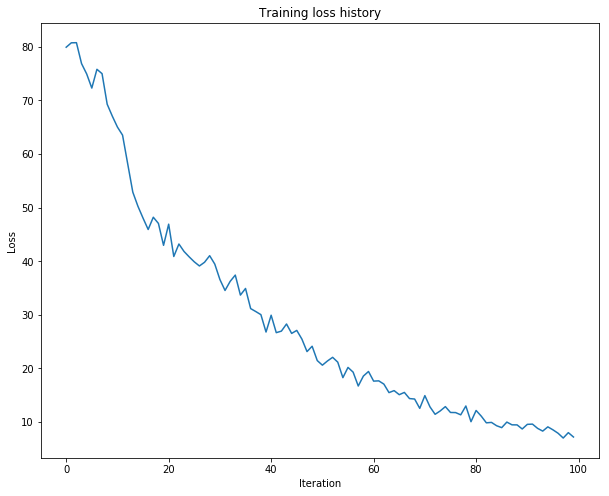

In [28]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

### LSTM test-time sampling

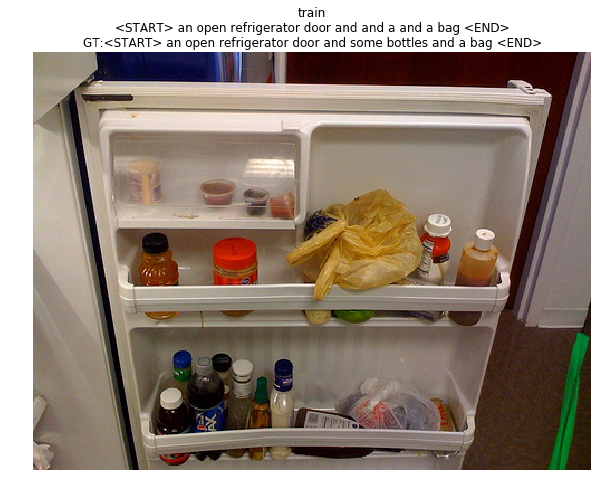

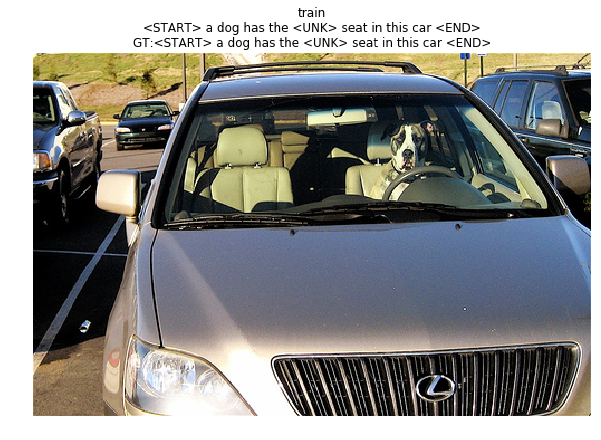

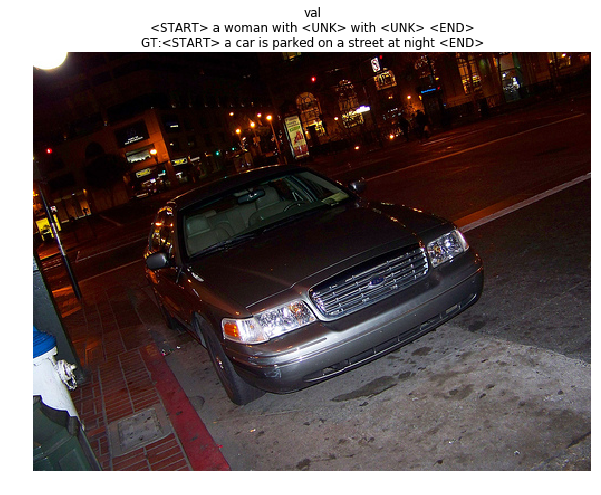

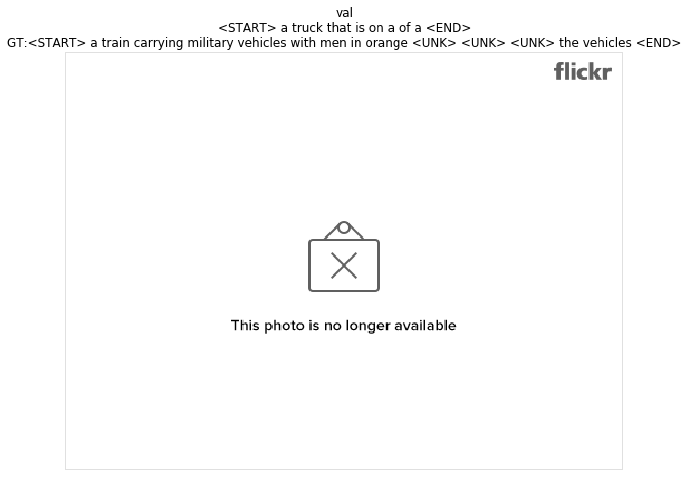

In [30]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()